## LDA Optimization Notebook Structure

### 1. Environment Setup


In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from typing import Dict, List, Any, Optional, Tuple
import logging
import sys
import os
import json
from pathlib import Path

# For LDA Topic Modeling
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import pyLDAvis


In [19]:
def load_data():
    """Load laptop and review data directly in the notebook."""
    DATA_DIR = Path("data")
    CSV_DIR = DATA_DIR / "csv"
    REVIEWS_DIR = DATA_DIR / "reviews"
    LAPTOPS_CSV = CSV_DIR / "gaming_laptops_with_reviews.csv"
    
    try:
        # Load laptop data
        laptop_data = pd.read_csv(LAPTOPS_CSV)
        print(f"Loaded {len(laptop_data)} laptop records")
        
        # Load review data
        reviews = []
        for review_file in REVIEWS_DIR.glob("*.json"):
            with open(review_file, 'r') as f:
                review_data = json.load(f)
                reviews.extend(review_data)
        print(f"Loaded {len(reviews)} reviews")
        
        return laptop_data, reviews
    except Exception as e:
        print(f"Error loading data: {e}")
        return None, None

# Usage
laptop_data, reviews = load_data()

Loaded 254 laptop records
Loaded 1270 reviews


### 2. Data Loading

In [38]:
def load_data():
    """Load laptop and review data directly in the notebook."""
    DATA_DIR = Path("data")
    CSV_DIR = DATA_DIR / "csv"
    REVIEWS_DIR = DATA_DIR / "reviews"
    LAPTOPS_CSV = CSV_DIR / "gaming_laptops_with_reviews.csv"
    
    try:
        # Load laptop data
        laptop_data = pd.read_csv(LAPTOPS_CSV)
        print(f"Loaded {len(laptop_data)} laptop records")
        
        # Load review data
        reviews = []
        for review_file in REVIEWS_DIR.glob("*.json"):
            with open(review_file, 'r') as f:
                review_data = json.load(f)
                reviews.extend(review_data)
        print(f"Loaded {len(reviews)} reviews")
        
        return laptop_data, reviews
    except Exception as e:
        print(f"Error loading data: {e}")
        return None, None

# Usage
laptop_data, reviews = load_data()

Loaded 254 laptop records
Loaded 1270 reviews


 ### 3. Vectorization and Trainning


In [ ]:

# Define constants from production code
NUM_TOPICS = 5  # Number of topics for LDA
NUM_WORDS_PER_TOPIC = 10  # Number of words to display per topic

# Load processed reviews
processed_reviews_path = "data/processed/processed_reviews_20250522_152822.csv"
try:
    reviews_df = pd.read_csv(processed_reviews_path)
    print(f"Loaded {len(reviews_df)} processed reviews from {processed_reviews_path}")
    
    # Check the columns
    print(f"Columns in the dataframe: {reviews_df.columns.tolist()}")
    
    # Extract review texts
    if 'cleaned_text' in reviews_df.columns:
        all_reviews = reviews_df['cleaned_text'].dropna().tolist()
    elif 'text' in reviews_df.columns:
        all_reviews = reviews_df['text'].dropna().tolist()
    else:
        # If neither column exists, try to find a text column
        text_columns = [col for col in reviews_df.columns if 'text' in col.lower()]
        if text_columns:
            all_reviews = reviews_df[text_columns[0]].dropna().tolist()
        else:
            all_reviews = []
            print("No text column found in the dataframe")
    
    # Check if we have reviews to process
    print(f"Total reviews for analysis: {len(all_reviews)}")
    
    if all_reviews:
        # Print a sample review
        print(f"Sample review: {all_reviews[0][:100]}...")
        
        # Basic text preprocessing
        def preprocess_text(text):
            if not isinstance(text, str):
                return ""
            # Convert to lowercase
            text = text.lower()
            # Remove special characters and digits
            text = re.sub(r'[^\w\s]', ' ', text)
            text = re.sub(r'\d+', ' ', text)
            # Remove extra whitespace
            text = re.sub(r'\s+', ' ', text).strip()
            return text
        
        # Preprocess reviews
        preprocessed_reviews = [preprocess_text(review) for review in all_reviews]
        preprocessed_reviews = [review for review in preprocessed_reviews if len(review) > 10]  # Filter out very short reviews
        
        print(f"Preprocessed {len(preprocessed_reviews)} reviews")
        
        # Create document-term matrix
        from sklearn.feature_extraction.text import CountVectorizer
        
        vectorizer = CountVectorizer(
            max_df=0.95,  # Ignore terms that appear in >95% of documents
            min_df=2,     # Ignore terms that appear in <2 documents
            stop_words='english',
            max_features=1000 
        )
        
        try:
            X = vectorizer.fit_transform(preprocessed_reviews)
            feature_names = vectorizer.get_feature_names_out()
            
            print(f"Document-term matrix shape: {X.shape}")
            print(f"Vocabulary size: {len(feature_names)}")
            
            # Train LDA model
            from sklearn.decomposition import LatentDirichletAllocation
            
            lda_model = LatentDirichletAllocation(
                n_components=NUM_TOPICS,
                max_iter=10,
                learning_method='online',
                random_state=42,
                batch_size=128,
                evaluate_every=-1
            )
            
            lda_model.fit(X)
            
            # Extract topic words
            topic_words = []
            for topic_idx, topic in enumerate(lda_model.components_):
                top_words_idx = topic.argsort()[:-NUM_WORDS_PER_TOPIC-1:-1]
                top_words = [feature_names[i] for i in top_words_idx]
                topic_words.append(top_words)
                print(f"Topic #{topic_idx}: {', '.join(top_words)}")
            
            # Calculate perplexity (lower is better)
            perplexity = lda_model.perplexity(X)
            print(f"Model perplexity: {perplexity:.2f}")
            
        except ValueError as e:
            print(f"Error in vectorization or LDA: {e}")
            print("This often happens when the vocabulary is empty after filtering.")
            print("Try adjusting the vectorizer parameters or check your text preprocessing.")
    else:
        print("No reviews found after filtering. Please check your data.")
        
except Exception as e:
    print(f"Error loading processed reviews: {e}")


Loaded 1270 processed reviews from data/processed/processed_reviews_20250522_152822.csv
Columns in the dataframe: ['review_id', 'rating', 'text', 'date', 'cleaned_text', 'review_length']
Total reviews for analysis: 1270
Sample review: Absolutely love this laptop The performance for content creation and gaming is incredible especially...
Preprocessed 1270 reviews
Document-term matrix shape: (1270, 494)
Vocabulary size: 494
Topic #0: bit, nvidia, good, gtx, geforce, windows, memory, th, ghz, gen
Topic #1: performance, ram, core, gtx, intel, hd, throttles, backlit, tb, ssd
Topic #2: nvidia, gtx, looking, like, fast, performance, love, handles, incredible, notch
Topic #3: nvidia, battery, life, gtx, decent, purchase, satisfied, powerhouse, perfect, exceeded
Topic #4: build, price, quality, ssd, stars, getting, fantastic, use, joy, amazing
Model perplexity: 134.67


### 4. Topic Visualization



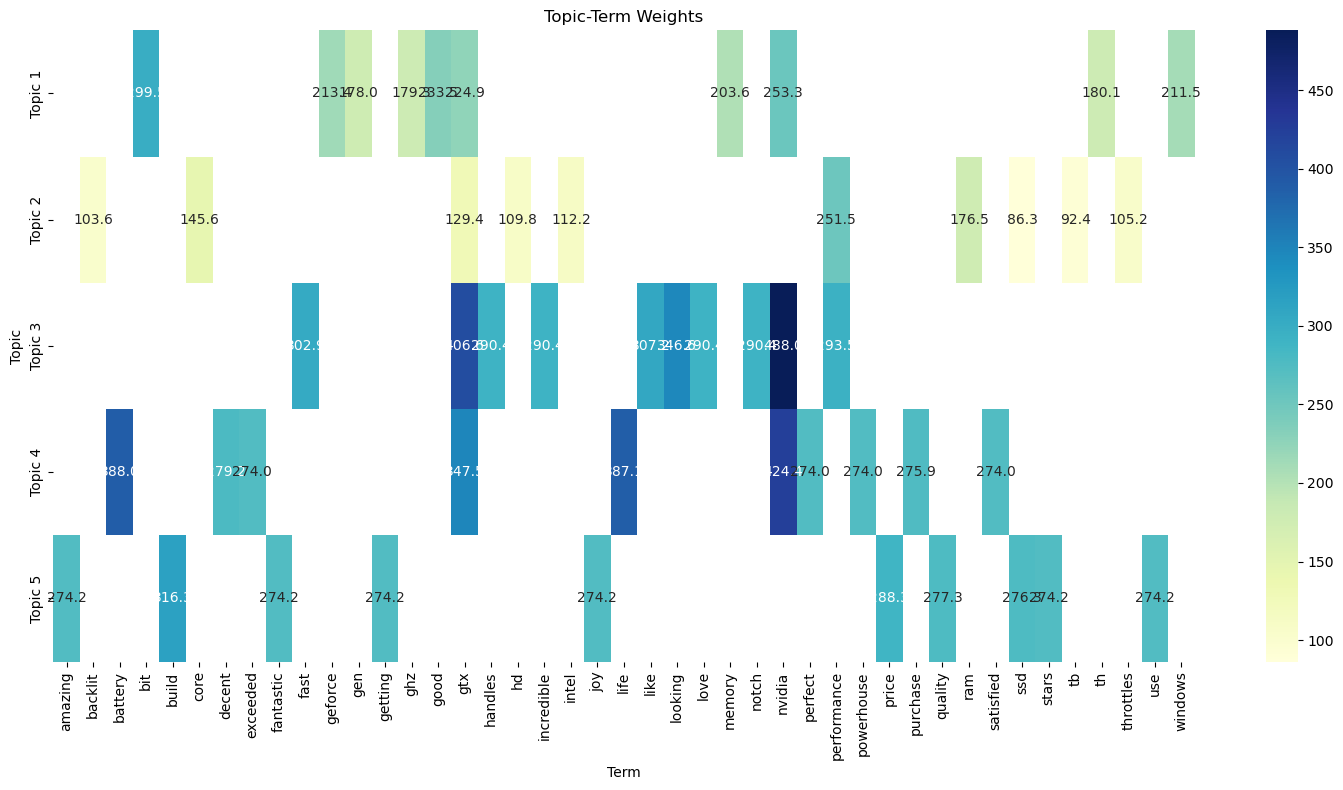

In [46]:
# Get top terms for each topic
n_top_words = 10
topic_terms = []
for topic_idx, topic in enumerate(lda_model.components_):
    top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
    top_terms = [feature_names[i] for i in top_features_ind]
    topic_terms.append(top_terms)

# Create a DataFrame for the heatmap
topic_term_weights = []
for topic_idx, topic in enumerate(lda_model.components_):
    for term_idx in topic.argsort()[:-n_top_words - 1:-1]:
        topic_term_weights.append({
            'Topic': f'Topic {topic_idx+1}',
            'Term': feature_names[term_idx],
            'Weight': topic[term_idx]
        })

df = pd.DataFrame(topic_term_weights)
pivot_df = df.pivot(index='Topic', columns='Term', values='Weight')

# Plot heatmap
plt.figure(figsize=(15, 8))
sns.heatmap(pivot_df, annot=True, cmap="YlGnBu", fmt=".1f")
plt.title('Topic-Term Weights')
plt.tight_layout()
plt.show()

### 5. Topic Quality Evaluation 

In [47]:
# Calculate perplexity (lower is better)
perplexity = lda_model.perplexity(X)
print(f"Model perplexity: {perplexity:.2f}")

# Function to calculate topic coherence (enhancement)
def calculate_topic_coherence(topic_words, texts, top_n=10):
    """Calculate simple coherence score for topics"""
    coherence_scores = []
    
    for topic in topic_words:
        topic = topic[:top_n]  # Use top N words
        score = 0
        pairs = 0
        
        # For each pair of words in topic
        for i in range(len(topic)):
            for j in range(i+1, len(topic)):
                word_i = topic[i]
                word_j = topic[j]
                co_occur = 0
                
                # Count co-occurrences in documents
                for doc in texts:
                    if word_i in doc and word_j in doc:
                        co_occur += 1
                
                # Add to score if words co-occur
                if co_occur > 0:
                    score += co_occur
                pairs += 1
        
        # Average score for this topic
        if pairs > 0:
            coherence_scores.append(score / pairs)
        else:
            coherence_scores.append(0)
    
    return coherence_scores

# Calculate coherence for current topics
coherence_scores = calculate_topic_coherence(topic_words, all_reviews)
for i, score in enumerate(coherence_scores):
    print(f"Topic {i} coherence: {score:.4f}")
print(f"Average coherence: {sum(coherence_scores)/len(coherence_scores):.4f}")

Model perplexity: 134.67
Topic 0 coherence: 21.3111
Topic 1 coherence: 2.0222
Topic 2 coherence: 179.8444
Topic 3 coherence: 64.3333
Topic 4 coherence: 128.3556
Average coherence: 79.1733


### 6. Topic Number Optimization

Topics: 2, Perplexity: 171.46, Coherence: 5.8778
Topics: 3, Perplexity: 154.13, Coherence: 21.5556
Topics: 4, Perplexity: 140.73, Coherence: 50.3167
Topics: 5, Perplexity: 134.67, Coherence: 79.1733
Topics: 6, Perplexity: 134.27, Coherence: 70.7222
Topics: 7, Perplexity: 124.58, Coherence: 52.6952
Topics: 8, Perplexity: 119.98, Coherence: 42.4750
Topics: 9, Perplexity: 122.93, Coherence: 56.4543
Topics: 10, Perplexity: 120.17, Coherence: 36.4978
Topics: 11, Perplexity: 120.17, Coherence: 39.7455
Topics: 12, Perplexity: 114.05, Coherence: 42.8667
Topics: 13, Perplexity: 113.94, Coherence: 37.1624
Topics: 14, Perplexity: 124.58, Coherence: 21.5095


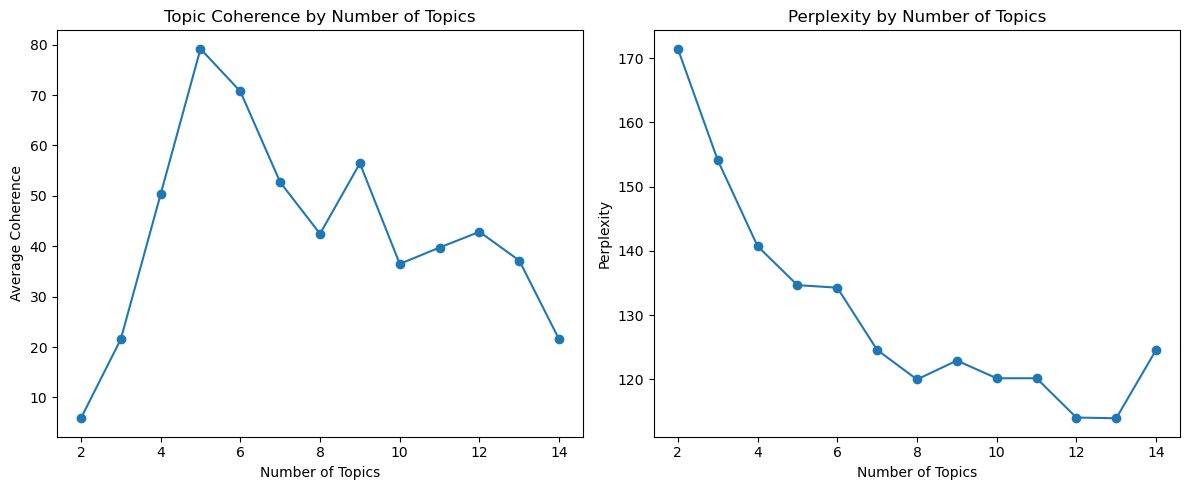

Optimal number of topics based on coherence: 5


In [48]:
# Test different numbers of topics (enhancement to production)
topic_range = range(2, 15, 1)
perplexities = []
coherences = []

for n_topics in topic_range:
    # Train model with this number of topics
    lda = LatentDirichletAllocation(
        n_components=n_topics,
        max_iter=10,
        learning_method='online',
        random_state=42,
        batch_size=128
    )
    
    lda.fit(X)
    
    # Calculate perplexity
    perplexity = lda.perplexity(X)
    perplexities.append(perplexity)
    
    # Extract topic words
    topics = []
    for topic_idx, topic in enumerate(lda.components_):
        top_words_idx = topic.argsort()[:-NUM_WORDS_PER_TOPIC-1:-1]
        top_words = [feature_names[i] for i in top_words_idx]
        topics.append(top_words)
    
    # Calculate coherence
    topic_coherences = calculate_topic_coherence(topics, all_reviews)
    coherences.append(sum(topic_coherences) / len(topic_coherences))
    
    print(f"Topics: {n_topics}, Perplexity: {perplexity:.2f}, Coherence: {coherences[-1]:.4f}")

# Plot results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(topic_range, coherences, marker='o')
plt.xlabel('Number of Topics')
plt.ylabel('Average Coherence')
plt.title('Topic Coherence by Number of Topics')

plt.subplot(1, 2, 2)
plt.plot(topic_range, perplexities, marker='o')
plt.xlabel('Number of Topics')
plt.ylabel('Perplexity')
plt.title('Perplexity by Number of Topics')

plt.tight_layout()
plt.show()

# Find optimal number of topics
optimal_idx = coherences.index(max(coherences))
optimal_topics = topic_range[optimal_idx]
print(f"Optimal number of topics based on coherence: {optimal_topics}")

### 8. Hyperparameter Tuning 

In [50]:
# Test different alpha and beta values (enhancement)
alphas = [0.01, 0.05, 0.1, 0.3, 0.5, 0.9]
betas = [0.01, 0.05, 0.1, 0.3, 0.5, 0.9]
results = []

for alpha in alphas:
    for beta in betas:
        lda = LatentDirichletAllocation(
            n_components=optimal_topics,
            doc_topic_prior=alpha,  # alpha
            topic_word_prior=beta,  # beta
            max_iter=10,
            learning_method='online',
            random_state=42
        )
        
        lda.fit(X)
        perplexity = lda.perplexity(X)
        
        # Extract topic words
        topics = []
        for topic_idx, topic in enumerate(lda.components_):
            top_words_idx = topic.argsort()[:-NUM_WORDS_PER_TOPIC-1:-1]
            top_words = [feature_names[i] for i in top_words_idx]
            topics.append(top_words)
        
        # Calculate coherence
        topic_coherences = calculate_topic_coherence(topics, all_reviews)
        coherence = sum(topic_coherences) / len(topic_coherences)
        
        results.append({
            'alpha': alpha,
            'beta': beta,
            'perplexity': perplexity,
            'coherence': coherence
        })
        
        print(f"Alpha: {alpha}, Beta: {beta}, Perplexity: {perplexity:.2f}, Coherence: {coherence:.4f}")

# Find optimal parameters
results_df = pd.DataFrame(results)
best_row = results_df.loc[results_df['coherence'].idxmax()]
best_alpha = best_row['alpha']
best_beta = best_row['beta']

print(f"Optimal parameters: Alpha = {best_alpha}, Beta = {best_beta}")

Alpha: 0.01, Beta: 0.01, Perplexity: 139.34, Coherence: 84.6756
Alpha: 0.01, Beta: 0.05, Perplexity: 134.34, Coherence: 93.2311
Alpha: 0.01, Beta: 0.1, Perplexity: 132.26, Coherence: 79.2400
Alpha: 0.01, Beta: 0.3, Perplexity: 129.77, Coherence: 79.0800
Alpha: 0.01, Beta: 0.5, Perplexity: 130.37, Coherence: 79.0844
Alpha: 0.01, Beta: 0.9, Perplexity: 132.48, Coherence: 71.7511
Alpha: 0.05, Beta: 0.01, Perplexity: 137.81, Coherence: 93.8178
Alpha: 0.05, Beta: 0.05, Perplexity: 132.78, Coherence: 93.8178
Alpha: 0.05, Beta: 0.1, Perplexity: 131.38, Coherence: 93.8178
Alpha: 0.05, Beta: 0.3, Perplexity: 129.94, Coherence: 79.0800
Alpha: 0.05, Beta: 0.5, Perplexity: 130.86, Coherence: 79.0844
Alpha: 0.05, Beta: 0.9, Perplexity: 133.35, Coherence: 71.7511
Alpha: 0.1, Beta: 0.01, Perplexity: 139.00, Coherence: 79.1733
Alpha: 0.1, Beta: 0.05, Perplexity: 134.18, Coherence: 79.1733
Alpha: 0.1, Beta: 0.1, Perplexity: 132.77, Coherence: 79.1733
Alpha: 0.1, Beta: 0.3, Perplexity: 131.73, Coherence

### 9. Final Model with Optimal Parameters


Final optimized topics:
Topic #0: bit, nvidia, good, gtx, geforce, memory, windows, th, gen, ghz
Topic #1: performance, ram, core, gtx, intel, throttles, hd, backlit, tb, ssd
Topic #2: nvidia, gtx, looking, like, fast, performance, love, handles, incredible, notch
Topic #3: nvidia, life, gtx, battery, purchase, decent, powerhouse, perfect, satisfied, expectations
Topic #4: build, quality, price, stars, getting, fantastic, use, joy, amazing, definite


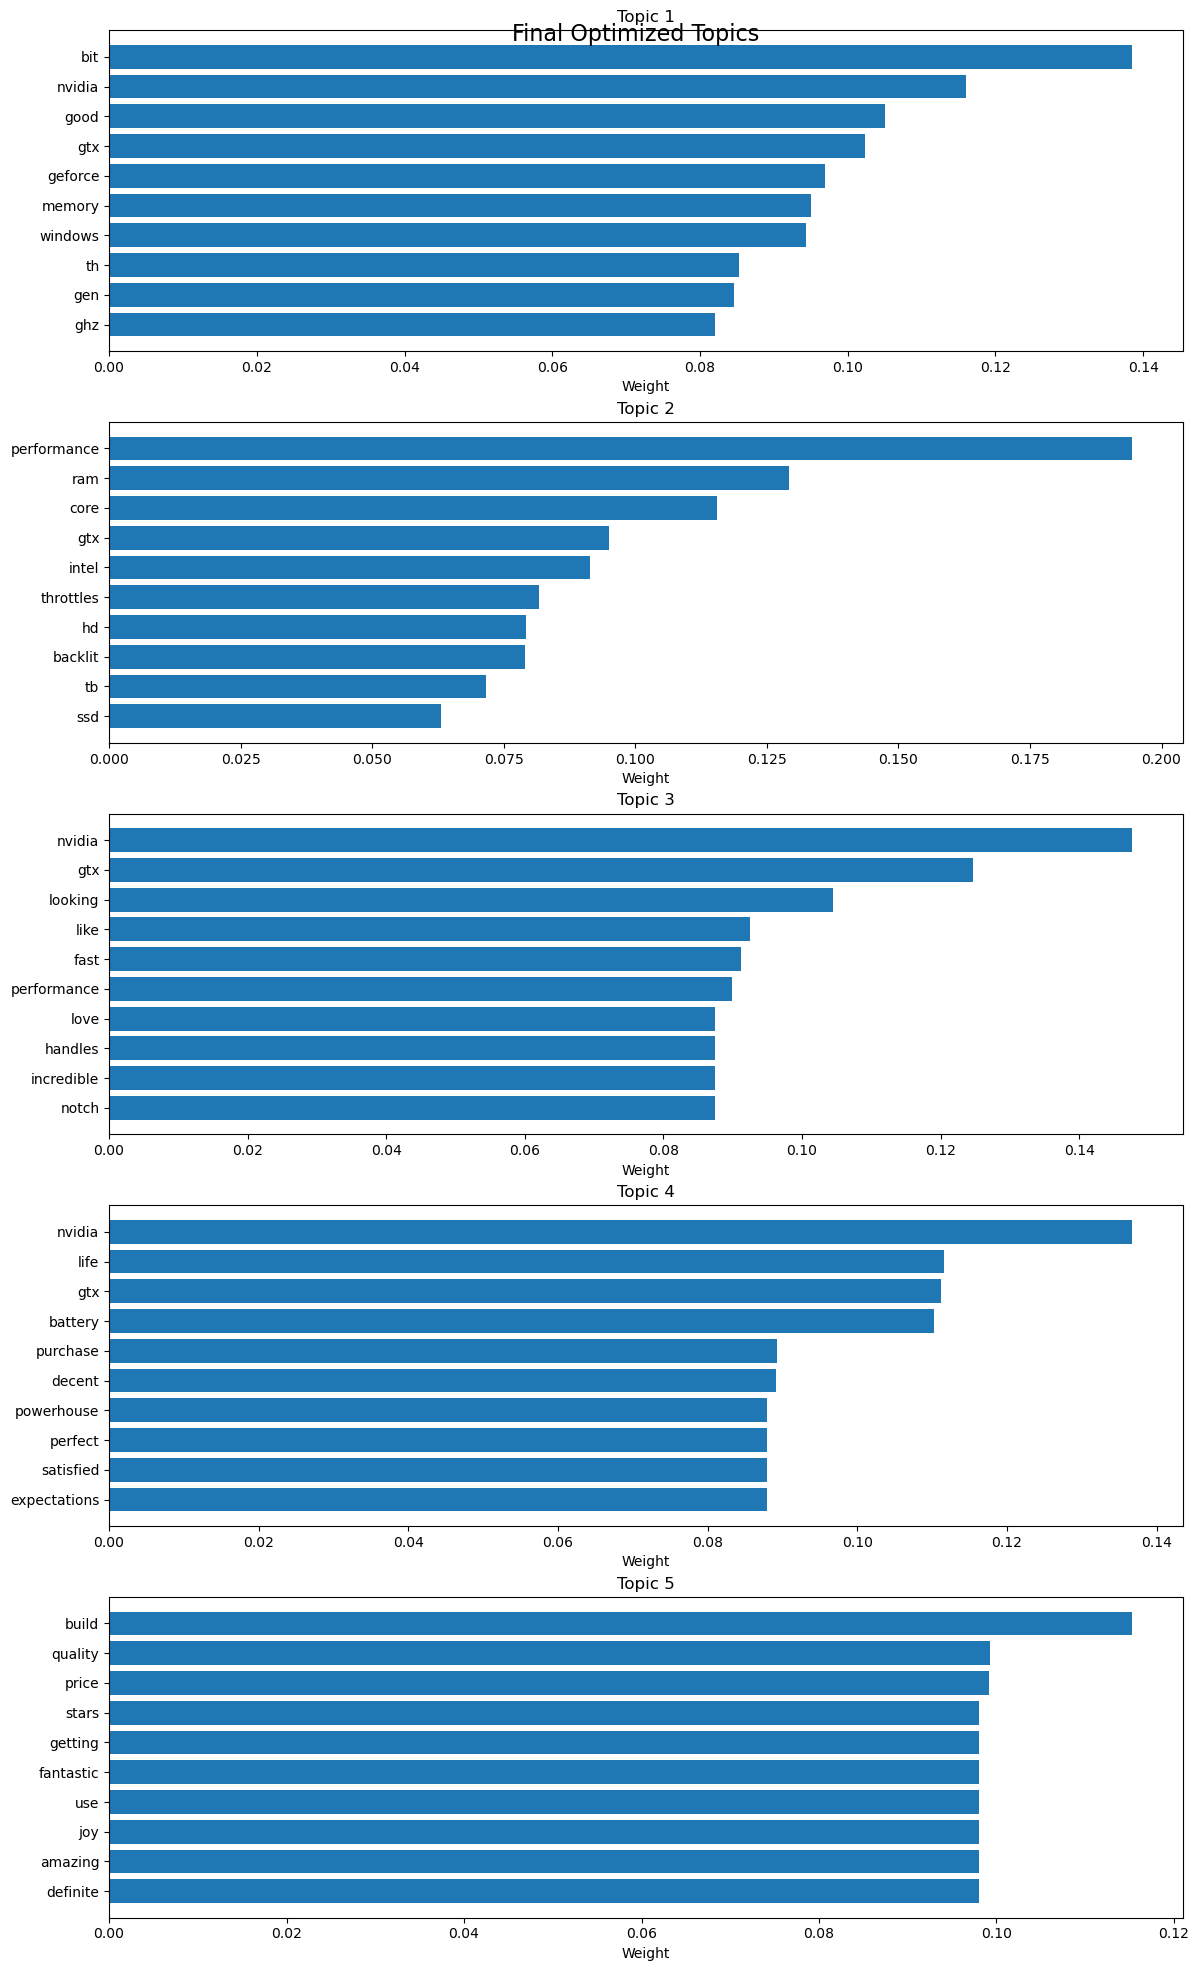

In [52]:
# Train final model with optimal parameters
final_lda = LatentDirichletAllocation(
    n_components=optimal_topics,
    doc_topic_prior=best_alpha,
    topic_word_prior=best_beta,
    max_iter=15,
    learning_method='online',
    random_state=42
)

final_lda.fit(X)

# Extract and display final topics
final_topics = []
print("\nFinal optimized topics:")
for topic_idx, topic in enumerate(final_lda.components_):
    top_words_idx = topic.argsort()[:-NUM_WORDS_PER_TOPIC-1:-1]
    top_words = [feature_names[i] for i in top_words_idx]
    final_topics.append(top_words)
    print(f"Topic #{topic_idx}: {', '.join(top_words)}")

# Create a figure with subplots for each topic
fig, axes = plt.subplots(len(final_lda.components_), 1, figsize=(12, 4*len(final_lda.components_)))
fig.tight_layout(pad=3.0)

# Plot each topic
for i, (topic, ax) in enumerate(zip(final_lda.components_, axes)):
    # Get the top words and their weights
    top_words_idx = topic.argsort()[:-NUM_WORDS_PER_TOPIC-1:-1]
    top_words = [feature_names[j] for j in top_words_idx]
    weights = [topic[j] for j in top_words_idx]
    
    # Normalize weights for better visualization
    weights = [w/sum(weights) for w in weights]
    
    # Create horizontal bar chart
    y_pos = range(len(top_words))
    ax.barh(y_pos, weights, align='center')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(top_words)
    ax.invert_yaxis()  # Labels read top-to-bottom
    ax.set_title(f'Topic {i+1}')
    ax.set_xlabel('Weight')

plt.suptitle('Final Optimized Topics', fontsize=16)
plt.show()